# 0

Тут считаем объективные и субхективные метрики на сгенерированных примерах

`./metric_results`

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import os
import sys
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter, defaultdict

sys.path.append(os.path.abspath(".."))

sys.path.append('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_keyframe_detector')
sys.path.append("/storage/arkady/Glinka/music-transformer/video_conditioning/content/computervision-recipes")  # import utils_cv ...

os.environ['LD_PRELOAD'] = '/usr/lib/x86_64-linux-gnu/libffi.so.7'

selected_videos = [25, 5, 14, 17, 27]
ind = 2
path_mp4 = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
    / 'content' / 'video_data' / f'video_ad{selected_videos[ind]}.mp4'
assert os.path.exists(path_mp4)

In [2]:
import re

re.match(r'.*\.mid', '/storage/arkady/Glinka/Video2Music_/output/video_ad25___D_major___.mid')

<re.Match object; span=(0, 70), match='/storage/arkady/Glinka/Video2Music_/output/video_>

In [3]:
# import shutil
# root = Path('/storage/arkady/Glinka/Video2Music_/output')
# for file in os.listdir(root):
# 	if not re.match(r'.*___.*\.mid', file):
# 		continue
# 	print(root / file)

# conc score calculation

In [14]:
def get_middles(arr):
    ret = []
    for i in range(len(arr) - 1):
        ret += [(arr[i] + arr[i + 1])/2]
    return ret

arr = [1,3,61,123]
get_middles(arr)

[2.0, 32.0, 92.0]

In [126]:
from video_utils.metrics import get_key_midi_moments
from video_utils.metrics import concordance_score
import re

model_paths = [
    'model_v2m',
    'model_nnotes',
    'model_variations',
    'model_velocity',
    'model_original'
    ]

def get_middles(arr):
    ret = []
    for i in range(len(arr) - 1):
        ret += [(arr[i] + arr[i + 1])/2]
    return ret


results = {}
kvm_videos = json.load(open('kvm_threshold_only1_cut.json', 'r'))
kmm = {}
video_durations = json.load(open('video_durations.json', 'r'))
method = ['velocity', 'density'][0]

for model_path in model_paths:
    midi_files = [file for file in os.listdir(model_path) if
                   re.match(r'.*\.midi?$', file)
               ]
    print(f"\n{model_path=}")

    results[model_path] = {}
    for midi_file in tqdm(midi_files[:]):
        # print(f"{midi_file=}")

        video_stem = re.findall(r'.*(video_ad[0-9]*).*', midi_file)[0] #+ '.mp4'
        if (not video_stem) or (video_stem not in kvm_videos):
            print(f'skipping {midi_file=}, {video_stem=}')
            continue

        duration = video_durations[video_stem]
        key_video_moments = kvm_videos[video_stem]
        # Выделяем середины
        # key_video_moments = get_middles(key_video_moments)

        key_midi_moments = get_key_midi_moments(
            path_midi=Path(model_path) / midi_file,
            method=method,  # try 'density'
            key_moments_count=len(key_video_moments) * 1, # try bigger values,
            duration=(duration if model_path == 'model_v2m' else None)
            )

        score = concordance_score(  # try different params
            video_moments=key_video_moments, 
            music_moments=key_midi_moments, 
            alpha=1.0, 
            offset=2, 
            eps=2, 
            version='SUM', 
            symmetric=False
        )
        
        # print(score)
        results[model_path][midi_file] = score

json.dump(results, open('results_concordance.json', 'w'), indent=4)


model_path='model_v2m'


  0%|          | 0/30 [00:00<?, ?it/s]/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
100%|██████████| 30/30 [00:34<00:00,  1.13s/it]



model_path='model_nnotes'


100%|██████████| 13/13 [00:09<00:00,  1.39it/s]



model_path='model_variations'


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]



model_path='model_velocity'


100%|██████████| 31/31 [00:33<00:00,  1.07s/it]



model_path='model_original'


100%|██████████| 84/84 [00:34<00:00,  2.40it/s]


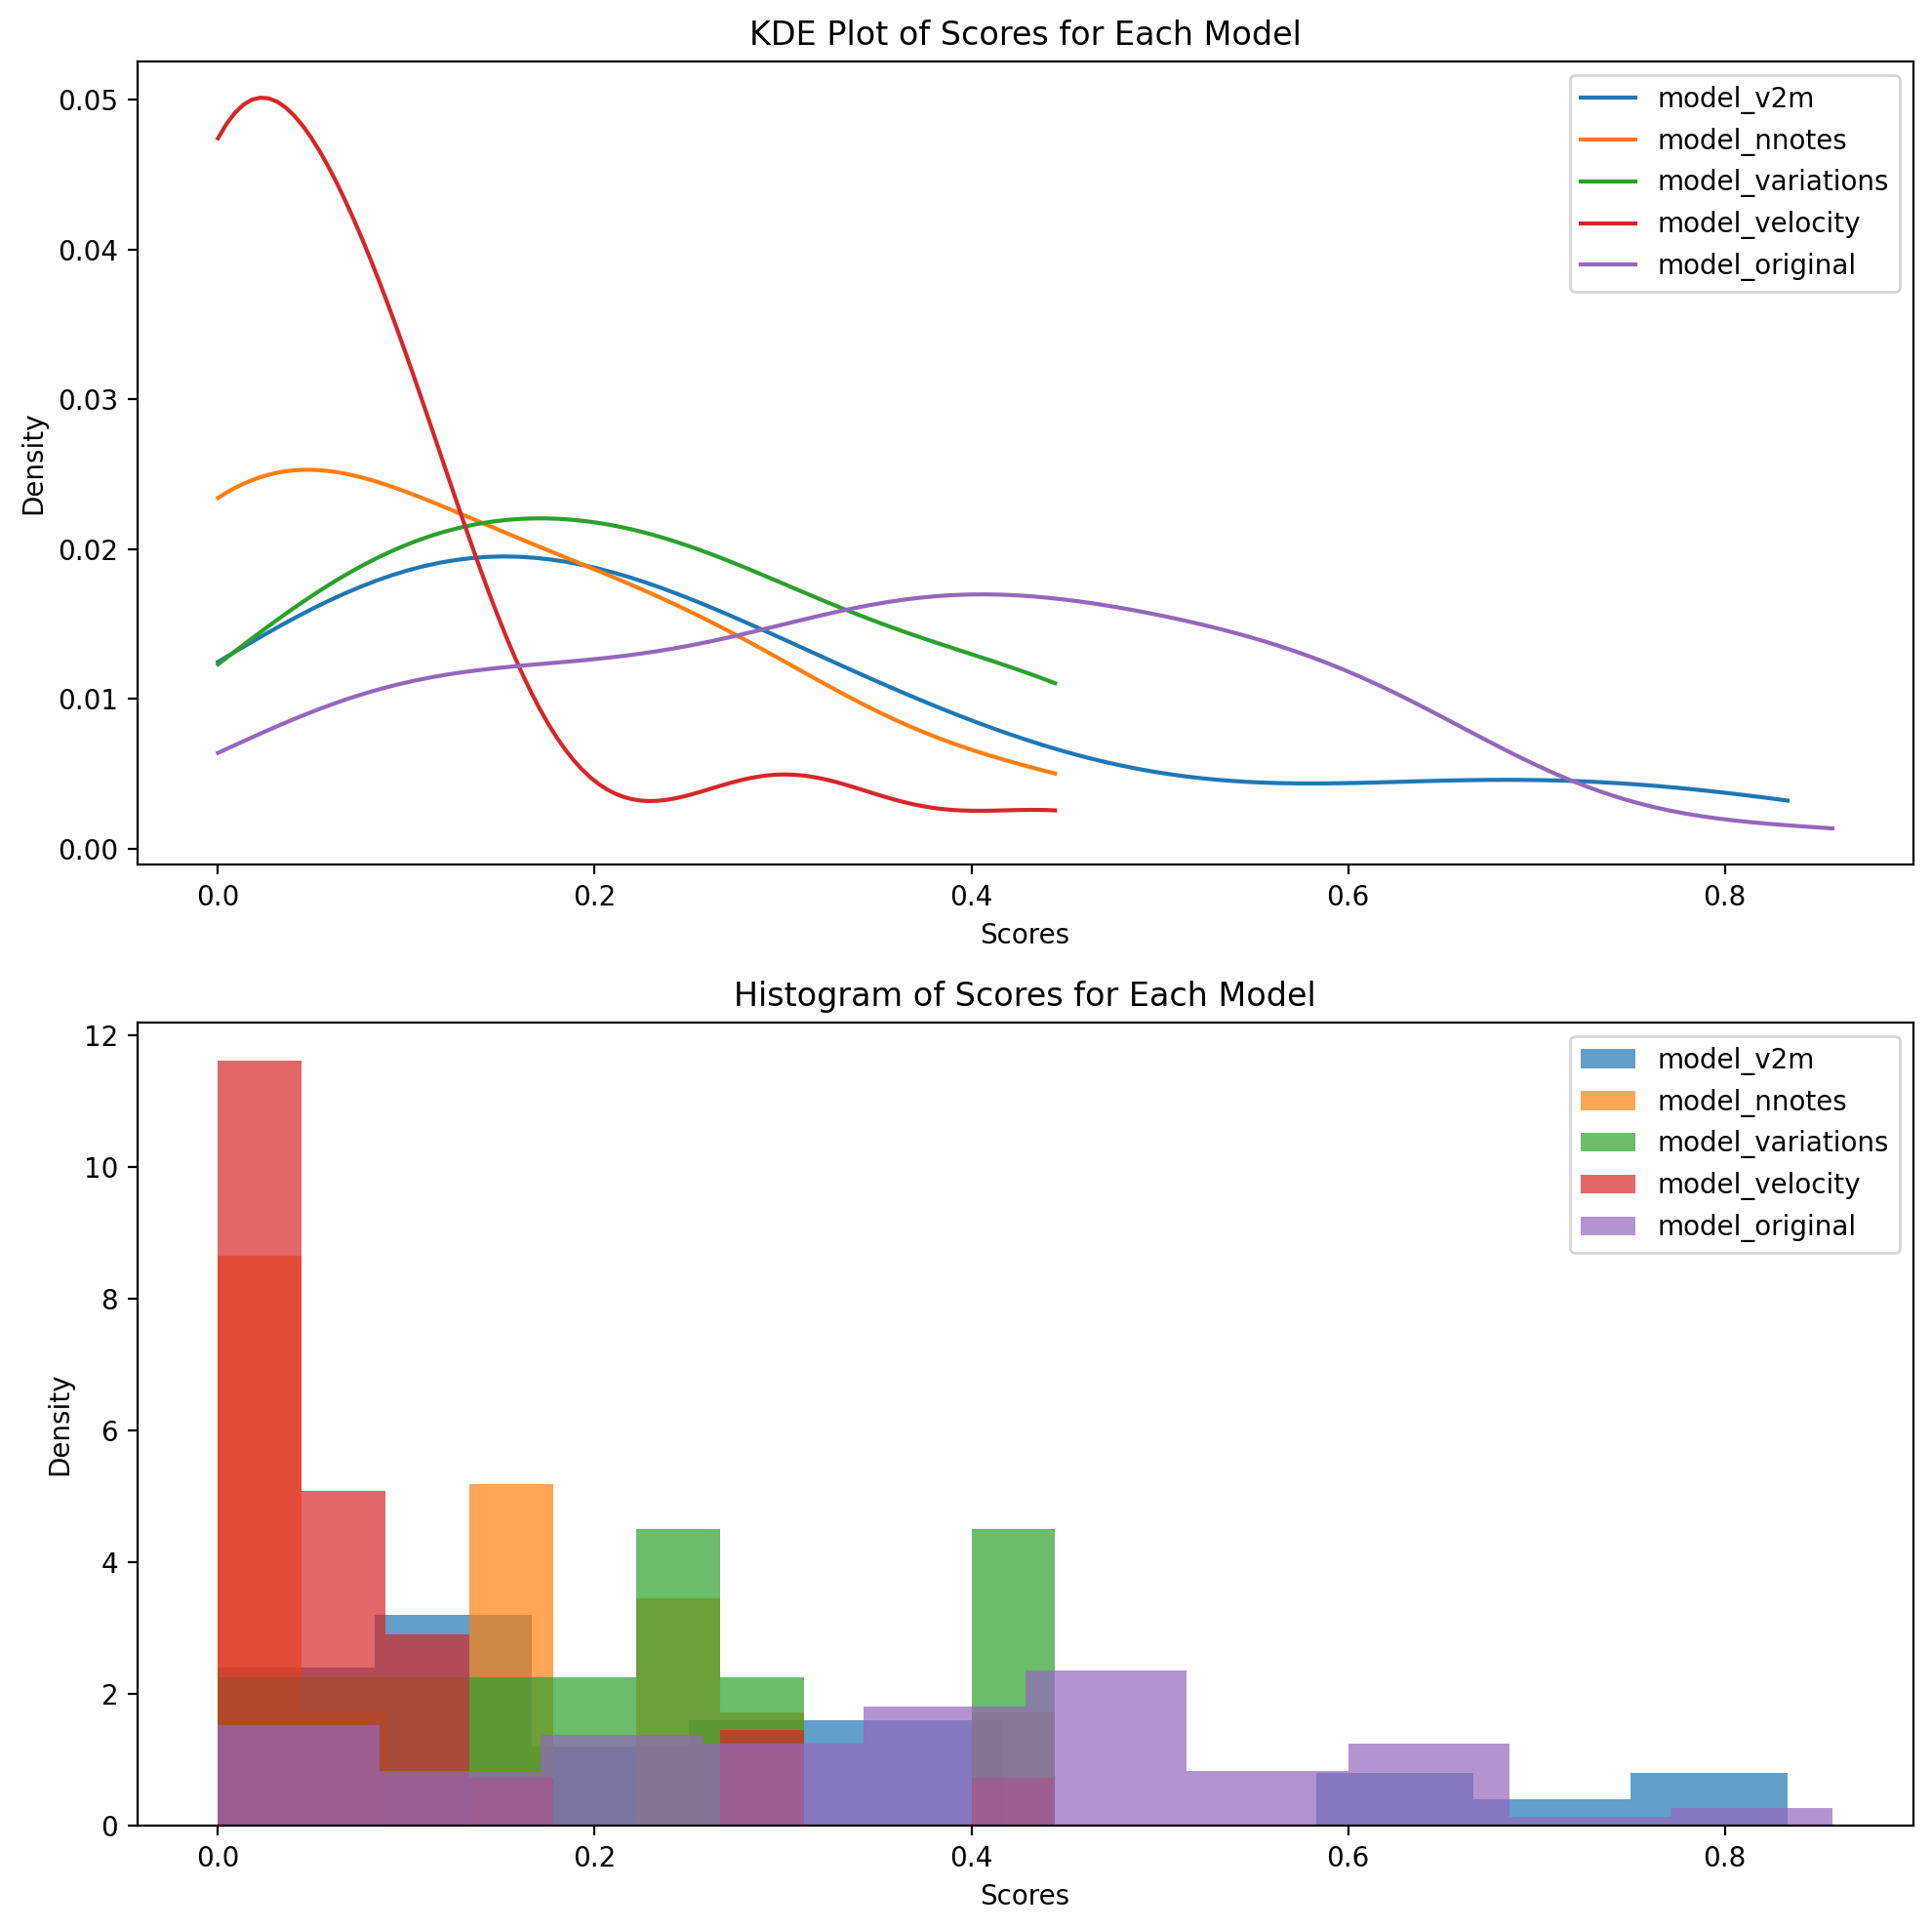

,count,mean,std,min,25%,50%,75%,max
model_v2m,30.000000,0.263329,0.234482,0.000000,0.108333,0.181818,0.363636,0.833333
model_nnotes,13.000000,0.133568,0.142867,0.000000,0.000000,0.133333,0.250000,0.444444
model_variations,10.000000,0.218316,0.150575,0.000000,0.108333,0.215909,0.293269,0.444444
model_velocity,31.000000,0.067121,0.105199,0.000000,0.000000,0.000000,0.091667,0.444444
model_original,84.000000,0.361634,0.202877,0.000000,0.181818,0.375000,0.500000,0.857143


In [127]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# Read JSON data from file
with open('results_concordance.json', 'r') as file:
    data = json.load(file)

# Extract scores and create a DataFrame with different lengths
scores = {model: pd.Series(list(videos.values())) for model, videos in data.items()}
df = pd.DataFrame(scores)

# Plot KDE for each model
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
for model in df.columns:
    if not df[model].dropna().empty:
        kde = gaussian_kde(df[model].dropna())
        x = np.linspace(min(df[model].dropna()), max(df[model].dropna()), 100)
        y = np.array(kde(x))
        plt.plot(x, y / len(y), label=model)

plt.xlabel('Scores')
plt.ylabel('Density')
plt.title('KDE Plot of Scores for Each Model')
plt.legend(loc='upper right')

# Plot raw histogram for each model
plt.subplot(2, 1, 2)
for model in df.columns:
    plt.hist(df[model].dropna(), bins=10, alpha=0.7, density=True, label=model)

plt.xlabel('Scores')
plt.ylabel('Density')
plt.title('Histogram of Scores for Each Model')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Calculate and print statistics
statistics = df.describe().transpose()
# print(statistics)
statistics.style.background_gradient()

# Additional statistics
# additional_stats = df.aggregate([np.median, np.std])
# print(additional_stats)


## boxplot of scores

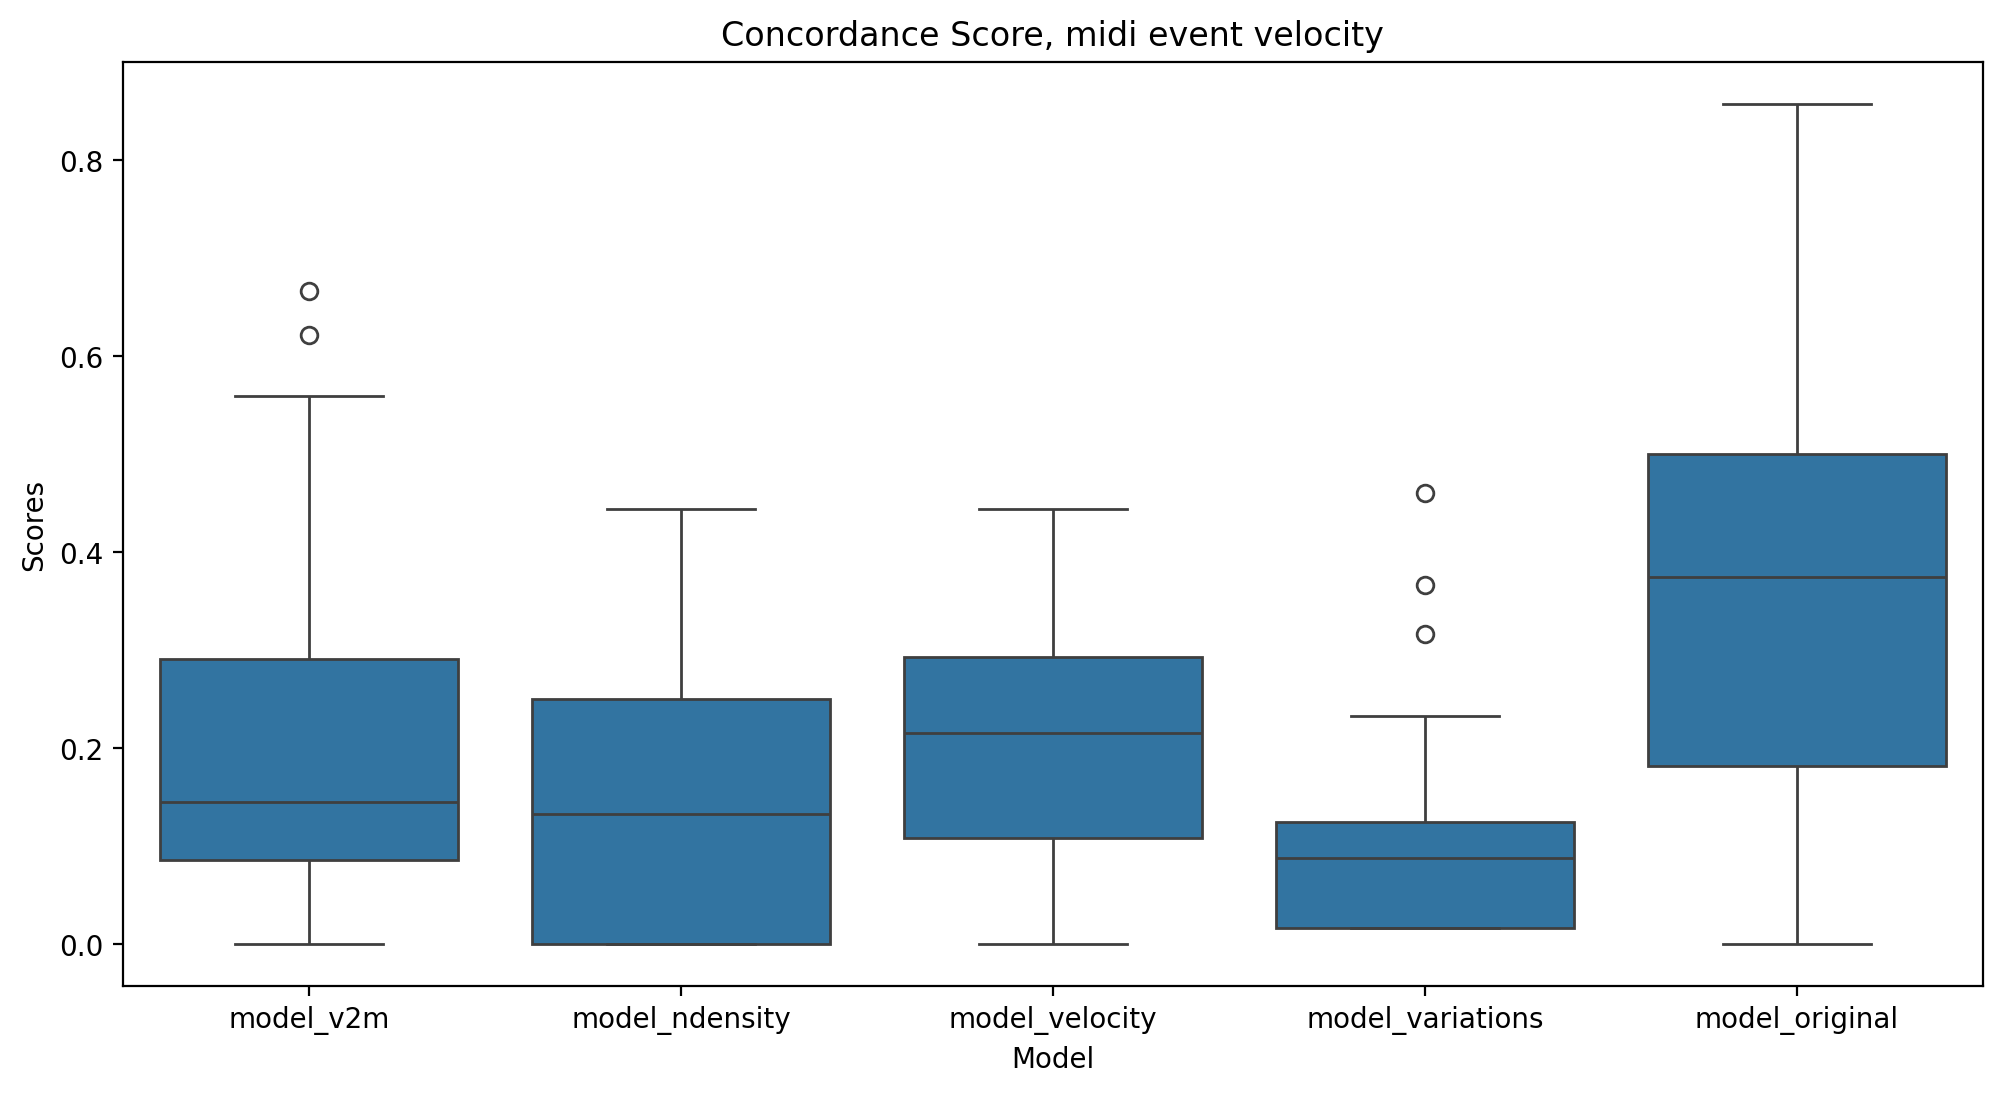

,count,mean,std,min,25%,50%,75%,max
model_v2m,30.000000,0.210663,0.187585,0.000000,0.086667,0.145455,0.290909,0.666667
model_ndensity,13.000000,0.133568,0.142867,0.000000,0.000000,0.133333,0.250000,0.444444
model_velocity,10.000000,0.218316,0.150575,0.000000,0.108333,0.215909,0.293269,0.444444
model_variations,31.000000,0.103680,0.108369,0.016667,0.016667,0.088095,0.125000,0.461111
model_original,84.000000,0.361634,0.202877,0.000000,0.181818,0.375000,0.500000,0.857143


In [130]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Read JSON data from file
with open('results_concordance.json', 'r') as file:
    data = json.load(file)

# Extract scores and create a DataFrame with different lengths
scores = {model: list(videos.values()) for model, videos in data.items()}
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in scores.items()]))


# Melt the DataFrame for use with seaborn
df_melted = df.melt(var_name='Model', value_name='Scores')


# Plot a single boxplot for score distribution for each model
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='Scores', data=df_melted)
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title(f'Concordance Score, midi event {method}')
# plt.savefig(f'plots/boxplot_3_scores_{method}_{np.random.randint(0, 999)}.png')
plt.savefig(f'plots/boxplot_4_scores_{method}.png')
plt.show()

# Calculate and print statistics
statistics = df.describe().transpose()
statistics.style.background_gradient()

# moving data

## nnotes

In [54]:
!ls ../generated_4x2x2/video_ad25_v2_rs0_g0/

video_ad25_v2_rs0_g0_kvm.mp4  video_ad25_v2_rs0_g0.mp4
video_ad25_v2_rs0_g0.midi     video_ad25_v2_rs0_g0_params.json
video_ad25_v2_rs0_g0.mp3


In [57]:
import shutil
for path in sorted(Path('../generated_4x2x2').rglob('*')):
    if not path.is_file() or not re.match(r'.*rs.*.midi', str(path)):
        continue
    print(path)
    # shutil.copyfile(src=path, dst='model_nnotes/' + Path(path).name)

../generated_4x2x2/video_ad14_v2_rs0_g0/video_ad14_v2_rs0_g0.midi
../generated_4x2x2/video_ad14_v2_rs0_g1/video_ad14_v2_rs0_g1.midi
../generated_4x2x2/video_ad14_v2_rs0_g11/video_ad14_v2_rs0_g11.midi
../generated_4x2x2/video_ad14_v2_rs0_g2/video_ad14_v2_rs0_g2.midi
../generated_4x2x2/video_ad17_v2_rs0_g11/video_ad17_v2_rs0_g11.midi
../generated_4x2x2/video_ad25_v2_rs0_g0/video_ad25_v2_rs0_g0.midi
../generated_4x2x2/video_ad25_v2_rs0_g11/video_ad25_v2_rs0_g11.midi
../generated_4x2x2/video_ad25_v2_rs0_g2/video_ad25_v2_rs0_g2.midi
../generated_4x2x2/video_ad32_v2_rs0_g11/video_ad32_v2_rs0_g11.midi
../generated_4x2x2/video_ad38_v2_rs0_g11/video_ad38_v2_rs0_g11.midi
../generated_4x2x2/video_ad5_v2_rs0_g0/video_ad5_v2_rs0_g0.midi
../generated_4x2x2/video_ad5_v2_rs0_g11/video_ad5_v2_rs0_g11.midi
../generated_4x2x2/video_ad5_v2_rs0_g2/video_ad5_v2_rs0_g2.midi


In [58]:
import shutil
for path in sorted(Path('../generated_4x2x2').rglob('*')):
    if not path.is_file() or not re.match(r'.*rs.*.mp4', str(path)):
        continue
    print(path)
    shutil.copyfile(src=path, dst='model_nnotes/' + Path(path).name)

../generated_4x2x2/video_ad14_v2_rs0_g0/video_ad14_v2_rs0_g0.mp4
../generated_4x2x2/video_ad14_v2_rs0_g0/video_ad14_v2_rs0_g0_kvm.mp4
../generated_4x2x2/video_ad14_v2_rs0_g1/video_ad14_v2_rs0_g1.mp4
../generated_4x2x2/video_ad14_v2_rs0_g1/video_ad14_v2_rs0_g1_kvm.mp4
../generated_4x2x2/video_ad14_v2_rs0_g11/video_ad14_v2_rs0_g11.mp4
../generated_4x2x2/video_ad14_v2_rs0_g11/video_ad14_v2_rs0_g11_kvm.mp4
../generated_4x2x2/video_ad14_v2_rs0_g2/video_ad14_v2_rs0_g2.mp4
../generated_4x2x2/video_ad14_v2_rs0_g2/video_ad14_v2_rs0_g2_kvm.mp4
../generated_4x2x2/video_ad17_v2_rs0_g11/video_ad17_v2_rs0_g11.mp4
../generated_4x2x2/video_ad17_v2_rs0_g11/video_ad17_v2_rs0_g11_kvm.mp4
../generated_4x2x2/video_ad25_v2_rs0_g0/video_ad25_v2_rs0_g0.mp4
../generated_4x2x2/video_ad25_v2_rs0_g0/video_ad25_v2_rs0_g0_kvm.mp4
../generated_4x2x2/video_ad25_v2_rs0_g11/video_ad25_v2_rs0_g11.mp4
../generated_4x2x2/video_ad25_v2_rs0_g11/video_ad25_v2_rs0_g11_kvm.mp4
../generated_4x2x2/video_ad25_v2_rs0_g2/video_ad25

In [ ]:
from video_utils.metrics import *

path_midi = './model_velocity/video_ad14_genre_classical_sentiment_0.midi'
path_midi = 'model_v2m/video_ad5___C_major___C_Am_F_G.mid'


base_midi = open_midi(path_midi, False)

measures = base_midi.parts[0].getElementsByClass(stream.Measure)

In [ ]:
measures[-10:]

[<music21.stream.Measure 142 offset=564.0>,
 <music21.stream.Measure 143 offset=568.0>,
 <music21.stream.Measure 144 offset=572.0>,
 <music21.stream.Measure 145 offset=576.0>,
 <music21.stream.Measure 146 offset=580.0>,
 <music21.stream.Measure 147 offset=584.0>,
 <music21.stream.Measure 148 offset=588.0>,
 <music21.stream.Measure 149 offset=592.0>,
 <music21.stream.Measure 150 offset=596.0>,
 <music21.stream.Measure 151 offset=600.0>]

In [ ]:
measures[4].flat.notes[0].volume.velocity, \
len(measures[4].flat.notes), \
    measures[4].flat.notes[0]

(84, 7, <music21.note.Note C>)

## variations

In [9]:
from pathlib import Path
import shutil
import re

regex = re.compile(r'.*/.*\d{4,5}/[^/]*\.(midi?|mp3)$')

for path in Path('/storage/arkady/Glinka/forma/music-transformer/generated_4x2x2/').rglob('*'):
    # print(path)
    if regex.match(str(path)):
        # print(path)
        pass
    else:
        continue
    print(path)
    shutil.copyfile(src=path, dst='model_variations/' + Path(path).name)

!ls model_variations

/storage/arkady/Glinka/forma/music-transformer/generated_4x2x2/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs0_t5532_ngen12033/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs0_t5532_ngen12033.midi
/storage/arkady/Glinka/forma/music-transformer/generated_4x2x2/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs0_t5532_ngen12033/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs0_t5532_ngen12033.mp3
/storage/arkady/Glinka/forma/music-transformer/generated_4x2x2/variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022/variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022.mp3
/storage/arkady/Glinka/forma/music-transformer/generated_4x2x2/variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022/variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022.midi
/storage/arkady/Glinka/forma/music-transformer/generated_4x2x2/variations_video_ad38_A_A1_A2_A3_A4_A5_A6_rs1_t5101_ngen9359/variations_video_ad38_A_A1_A2_A3_A4_A5_A6_rs1_t5101_ngen9359.midi
/storage/arkady/Glinka/forma/music-trans

## v2m

In [3]:
!ls /storage/arkady/Glinka/Video2Music_/output_v2m

video_ad10___C_major___C_Am_F_G.flac  video_ad22___C_major___C_Am_F_G.flac
video_ad10___C_major___C_Am_F_G.mid   video_ad22___C_major___C_Am_F_G.mid
video_ad10___C_major___C_Am_F_G.mp4   video_ad22___C_major___C_Am_F_G.mp4
video_ad11___C_major___C_Am_F_G.flac  video_ad23___C_major___C_Am_F_G.flac
video_ad11___C_major___C_Am_F_G.mid   video_ad23___C_major___C_Am_F_G.mid
video_ad11___C_major___C_Am_F_G.mp4   video_ad23___C_major___C_Am_F_G.mp4
video_ad12___C_major___C_Am_F_G.flac  video_ad24___C_major___C_Am_F_G.flac
video_ad12___C_major___C_Am_F_G.mid   video_ad24___C_major___C_Am_F_G.mid
video_ad12___C_major___C_Am_F_G.mp4   video_ad24___C_major___C_Am_F_G.mp4
video_ad13___C_major___C_Am_F_G.flac  video_ad25___C_major___C_Am_F_G.flac
video_ad13___C_major___C_Am_F_G.mid   video_ad25___C_major___C_Am_F_G.mid
video_ad13___C_major___C_Am_F_G.mp4   video_ad25___C_major___C_Am_F_G.mp4
video_ad14___C_major___C_Am_F_G.flac  video_ad25___D_major___D_G_A_D.flac
video_ad14___C_major___C_Am_F_G.mi

In [4]:
!cp /storage/arkady/Glinka/Video2Music_/output_v2m/*.mid ./model_v2m

In [5]:
!cp /storage/arkady/Glinka/Video2Music_/output_v2m/*.mp4 ./model_v2m

# merging midi and video

## manually


In [4]:
from midi2audio import FluidSynth
from pydub import AudioSegment
import os

def midi_to_mp3(midi_path, mp3_path, soundfont_path=None):
    midi_path = str(midi_path)
    mp3_path = str(mp3_path)
    # Convert MIDI to WAV
    wav_path = midi_path.replace('.midi', '.wav').replace('.mid', '.wav')
    
    if soundfont_path:
        fluidsynth = FluidSynth(soundfont_path)
    else:
        fluidsynth = FluidSynth()
        
    fluidsynth.midi_to_audio(midi_path, wav_path)
    
    # Convert WAV to MP3
    audio = AudioSegment.from_wav(wav_path)
    audio.export(mp3_path, format="mp3")
    
    # Clean up temporary WAV file
    os.remove(wav_path)
    return mp3_path

from moviepy.editor import VideoFileClip, AudioFileClip

def merge_audio_video(mp3_path, mp4_path, output_path):
    mp3_path = str(mp3_path)
    mp4_path = str(mp4_path)
    output_path = str(output_path)

    # Load the video file
    video = VideoFileClip(mp4_path)
    
    # Load the audio file
    audio = AudioFileClip(mp3_path)
    
    # Check durations
    video_duration = video.duration
    audio_duration = audio.duration

    # if audio_duration < video_duration:
    #     print('11111')
    #     # If audio is shorter, add silence
    #     audio = audio.set_duration(video_duration)
    if audio_duration < video_duration:
        print('Audio is shorter, clipping video')
        # If audio is shorter, clip the video
        video = video.subclip(0, audio_duration)
    elif audio_duration > video_duration:
        print('222222')
        # If audio is longer, clip the end
        audio = audio.subclip(0, video_duration)
    
    # Set the new audio to the video
    final_video = video.set_audio(audio)
    
    # Write the result to a new video file
    # final_video.write_videofile(output_path, codec="libx264", audio_codec="aac")
    final_video.write_videofile(output_path, codec="libx264", audio_codec='libmp3lame', fps=video.fps)

    return output_path


path_videos = Path('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data')
path_video = path_videos / 'video_ad5.mp4'
path_midi = './model_velocity/video_ad14_genre_classical_sentiment_0.midi'
path_midi = './model_variations/variations_video_ad14_A_A1_A2_A3_A4_A5_A6_A7_rs1_t5128_ngen10696.midi'

# path_mp3 = midi_to_mp3(path_midi, 'variations_video_ad14_A_A1_A2_A3_A4_A5_A6_A7_rs1_t5128_ngen10696.mp3')

# path_mp4 = merge_audio_video(path_mp3, path_video, 'variations_video_ad14_A_A1_A2_A3_A4_A5_A6_A7_rs1_t5128_ngen10696.mp4')

## automatically vartions

In [11]:
from pathlib import Path
import re

regex = re.compile(r'.*/.*\d{4,5}/[^/]*\.(midi?|mp3)$')

for path in Path('model_variations/').rglob('*'):
    print(path)
    if os.path.exists(f'model_variations/{path.stem}.mp4'):
        print('SKIPPED')
        continue
    name_video = re.findall(r'variations_(video_ad\d*)_.*', str(path))[0]
    print(name_video)

    print(f'{path=}')
    path_mp3 = midi_to_mp3(path, f'model_variations/{path.stem}.mp3')

    path_video = path_videos / f'{name_video}.mp4'
    print(f'{path_video=}, {path_video.exists()}')

    path_mp4 = merge_audio_video(path_mp3, path_video, f'model_variations/{path.stem}.mp4')
    print(f'model_variations/{path.stem}.mp4')
    print()
    

model_variations/variations_video_ad32_A_A1_A2_A3_A4_A5_A6_rs1_t6006_ngen9359.mp3
SKIPPED
model_variations/variations_video_ad14_A_A1_A2_A3_A4_A5_A6_A7_rs0_t5128_ngen10696.midi
SKIPPED
model_variations/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs1_t5532_ngen12033.mp4
SKIPPED
model_variations/variations_video_ad5_A_A1_A2_A3_A4_A5_rs1_t3003_ngen8022.midi
SKIPPED
model_variations/variations_video_ad38_A_A1_A2_A3_A4_A5_A6_rs0_t5101_ngen9359.mp4
SKIPPED
model_variations/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs1_t5532_ngen12033.midi
SKIPPED
model_variations/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs1_t5532_ngen12033.mp3
SKIPPED
model_variations/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs0_t5532_ngen12033.midi
SKIPPED
model_variations/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs0_t5532_ngen12033.mp3
SKIPPED
model_variations/variations_video_ad5_A_A1_A2_A3_A4_A5_rs2_t3003_ngen8022.mp4
SKIPPED
model_variations/variations_video_ad38_A_A1_A2_A3_A4_A5_A6_rs1_t5

Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_variations/variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad5.mp4'), True
Audio is shorter, clipping video
Moviepy - Building video model_variations/variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022.mp4.
MoviePy - Writing audio in variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_variations/variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022.mp4



Moviepy - Done !
Moviepy - video ready model_variations/variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022.mp4
model_variations/variations_video_ad5_A_A1_A2_A3_A4_A5_rs0_t3003_ngen8022.mp4

model_variations/variations_video_ad14_A_A1_A2_A3_A4_A5_A6_A7_rs1_t5128_ngen10696.mp3
SKIPPED
model_variations/variations_video_ad32_A_A1_A2_A3_A4_A5_A6_rs1_t6006_ngen9359.midi
SKIPPED
model_variations/variations_video_ad38_A_A1_A2_A3_A4_A5_A6_rs1_t5101_ngen9359.mp4
SKIPPED
model_variations/variations_video_ad5_A_A1_A2_A3_A4_A5_rs2_t3003_ngen8022.mp3
SKIPPED
model_variations/variations_video_ad14_A_A1_A2_A3_A4_A5_A6_A7_rs0_t5128_ngen10696.mp4
SKIPPED


## automatically velocity

In [12]:
from pathlib import Path
import re


for path in Path('model_velocity/').rglob('*'):
    print(path)
    if os.path.exists(f'model_velocity/{path.stem}.mp4'):
        print('SKIPPED')
        continue
    name_video = re.findall(r'.*/(video_ad\d*)_.*', str(path))[0]
    print(name_video)

    print(f'{path=}')
    path_mp3 = midi_to_mp3(path, f'model_velocity/{path.stem}.mp3')

    path_video = path_videos / f'{name_video}.mp4'
    print(f'{path_video=}, {path_video.exists()}')

    path_mp4 = merge_audio_video(path_mp3, path_video, f'model_velocity/{path.stem}.mp4')
    print()

model_velocity/video_ad5_genre_pop_sentiment_0.midi
SKIPPED
model_velocity/video_ad25_genre_classical_sentiment_0.midi
SKIPPED
model_velocity/video_ad32_genre_rock_sentiment_0.midi
SKIPPED
model_velocity/video_ad5_genre_classical_sentiment_0.midi
SKIPPED
model_velocity/video_ad5_genre_rock_sentiment_0.mp3
SKIPPED
model_velocity/video_ad14_genre_classical_sentiment_0.midi
SKIPPED
model_velocity/variations_video_ad32_A_A1_A2_A3_A4_A5_A6_rs1_t6006_ngen9359.mp3
SKIPPED
model_velocity/video_ad14_genre_rock_sentiment_0.mp4
SKIPPED
model_velocity/video_ad38_genre_rock_sentiment_1.mp3
SKIPPED
model_velocity/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs1_t5532_ngen12033.mp4
SKIPPED
model_velocity/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs1_t5532_ngen12033.mp3
SKIPPED
model_velocity/video_ad25_genre_pop_sentiment_1.midi
SKIPPED
model_velocity/video_ad5_genre_rock_sentiment_1.mp4
SKIPPED
model_velocity/video_ad14_genre_pop_sentiment_1.midi
SKIPPED
model_velocity/video_ad24_genre_pop_

Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad25_genre_rock_sentiment_0.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad25.mp4'), True
222222
Moviepy - Building video model_velocity/video_ad25_genre_rock_sentiment_0.mp4.
MoviePy - Writing audio in video_ad25_genre_rock_sentiment_0TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad25_genre_rock_sentiment_0.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad25_genre_rock_sentiment_0.mp4

model_velocity/video_ad38_genre_pop_sentiment_1.mp4
SKIPPED
model_velocity/video_ad32_genre_classical_sentiment_1.midi
video_ad32
path=PosixPath('model_velocity/video_ad32_genre_classical_sentiment_1.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad32_genre_classical_sentiment_1.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad32.mp4'), True
222222
Moviepy - Building video model_velocity/video_ad32_genre_classical_sentiment_1.mp4.
MoviePy - Writing audio in video_ad32_genre_classical_sentiment_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad32_genre_classical_sentiment_1.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad32_genre_classical_sentiment_1.mp4

model_velocity/video_ad32_genre_rock_sentiment_0.mp4
SKIPPED
model_velocity/video_ad38_genre_rock_sentiment_1.mp4
SKIPPED
model_velocity/video_ad14_genre_classical_sentiment_0.mp4
SKIPPED
model_velocity/video_ad38_genre_classical_sentiment_0.midi
video_ad38
path=PosixPath('model_velocity/video_ad38_genre_classical_sentiment_0.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad38_genre_classical_sentiment_0.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad38.mp4'), True
222222
Moviepy - Building video model_velocity/video_ad38_genre_classical_sentiment_0.mp4.
MoviePy - Writing audio in video_ad38_genre_classical_sentiment_0TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad38_genre_classical_sentiment_0.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad38_genre_classical_sentiment_0.mp4

model_velocity/video_ad38_genre_classical_sentiment_1.mp4
SKIPPED
model_velocity/video_ad32_genre_rock_sentiment_1.midi
video_ad32
path=PosixPath('model_velocity/video_ad32_genre_rock_sentiment_1.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad32_genre_rock_sentiment_1.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad32.mp4'), True
Audio is shorter, clipping video
Moviepy - Building video model_velocity/video_ad32_genre_rock_sentiment_1.mp4.
MoviePy - Writing audio in video_ad32_genre_rock_sentiment_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad32_genre_rock_sentiment_1.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad32_genre_rock_sentiment_1.mp4

model_velocity/video_ad5_genre_pop_sentiment_1.midi
video_ad5
path=PosixPath('model_velocity/video_ad5_genre_pop_sentiment_1.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad5_genre_pop_sentiment_1.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad5.mp4'), True
222222
Moviepy - Building video model_velocity/video_ad5_genre_pop_sentiment_1.mp4.
MoviePy - Writing audio in video_ad5_genre_pop_sentiment_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad5_genre_pop_sentiment_1.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad5_genre_pop_sentiment_1.mp4

model_velocity/video_ad32_genre_pop_sentiment_1.midi
video_ad32
path=PosixPath('model_velocity/video_ad32_genre_pop_sentiment_1.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad32_genre_pop_sentiment_1.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad32.mp4'), True
Audio is shorter, clipping video
Moviepy - Building video model_velocity/video_ad32_genre_pop_sentiment_1.mp4.
MoviePy - Writing audio in video_ad32_genre_pop_sentiment_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad32_genre_pop_sentiment_1.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad32_genre_pop_sentiment_1.mp4

model_velocity/video_ad25_genre_pop_sentiment_0.midi
video_ad25
path=PosixPath('model_velocity/video_ad25_genre_pop_sentiment_0.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad25_genre_pop_sentiment_0.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad25.mp4'), True
Audio is shorter, clipping video
Moviepy - Building video model_velocity/video_ad25_genre_pop_sentiment_0.mp4.
MoviePy - Writing audio in video_ad25_genre_pop_sentiment_0TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad25_genre_pop_sentiment_0.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad25_genre_pop_sentiment_0.mp4

model_velocity/video_ad25_genre_rock_sentiment_1.mp4
SKIPPED
model_velocity/video_ad5_genre_pop_sentiment_0.mp4
SKIPPED
model_velocity/video_ad32_genre_classical_sentiment_0.midi
video_ad32
path=PosixPath('model_velocity/video_ad32_genre_classical_sentiment_0.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad32_genre_classical_sentiment_0.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad32.mp4'), True
222222
Moviepy - Building video model_velocity/video_ad32_genre_classical_sentiment_0.mp4.
MoviePy - Writing audio in video_ad32_genre_classical_sentiment_0TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad32_genre_classical_sentiment_0.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad32_genre_classical_sentiment_0.mp4

model_velocity/video_ad24_genre_pop_sentiment_0.mp4
SKIPPED
model_velocity/video_ad25_genre_classical_sentiment_1.midi
video_ad25
path=PosixPath('model_velocity/video_ad25_genre_classical_sentiment_1.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad25_genre_classical_sentiment_1.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad25.mp4'), True
222222
Moviepy - Building video model_velocity/video_ad25_genre_classical_sentiment_1.mp4.
MoviePy - Writing audio in video_ad25_genre_classical_sentiment_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad25_genre_classical_sentiment_1.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad25_genre_classical_sentiment_1.mp4

model_velocity/video_ad5_genre_rock_sentiment_1.mp3
SKIPPED
model_velocity/video_ad14_genre_classical_sentiment_1.midi
video_ad14
path=PosixPath('model_velocity/video_ad14_genre_classical_sentiment_1.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad14_genre_classical_sentiment_1.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad14.mp4'), True
222222
Moviepy - Building video model_velocity/video_ad14_genre_classical_sentiment_1.mp4.
MoviePy - Writing audio in video_ad14_genre_classical_sentiment_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad14_genre_classical_sentiment_1.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad14_genre_classical_sentiment_1.mp4

model_velocity/video_ad38_genre_pop_sentiment_0.mp3
SKIPPED
model_velocity/video_ad32_genre_pop_sentiment_0.mp4
SKIPPED
model_velocity/video_ad25_genre_pop_sentiment_1.mp4
SKIPPED
model_velocity/video_ad5_genre_classical_sentiment_1.mp3
SKIPPED
model_velocity/video_ad14_genre_pop_sentiment_0.midi
video_ad14
path=PosixPath('model_velocity/video_ad14_genre_pop_sentiment_0.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad14_genre_pop_sentiment_0.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad14.mp4'), True
222222
Moviepy - Building video model_velocity/video_ad14_genre_pop_sentiment_0.mp4.
MoviePy - Writing audio in video_ad14_genre_pop_sentiment_0TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad14_genre_pop_sentiment_0.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad14_genre_pop_sentiment_0.mp4

model_velocity/video_ad14_genre_rock_sentiment_1.midi
video_ad14
path=PosixPath('model_velocity/video_ad14_genre_rock_sentiment_1.midi')


Parameter '/home/arkady/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'model_velocity/video_ad14_genre_rock_sentiment_1.wav'..
path_video=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad14.mp4'), True
222222
Moviepy - Building video model_velocity/video_ad14_genre_rock_sentiment_1.mp4.
MoviePy - Writing audio in video_ad14_genre_rock_sentiment_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video model_velocity/video_ad14_genre_rock_sentiment_1.mp4



Moviepy - Done !
Moviepy - video ready model_velocity/video_ad14_genre_rock_sentiment_1.mp4

model_velocity/video_ad25_genre_pop_sentiment_1.mp3
SKIPPED
model_velocity/video_ad25_genre_classical_sentiment_0.mp3
SKIPPED
model_velocity/video_ad25_genre_classical_sentiment_0.mp4
SKIPPED


# moving and cutting kvm4 from '../kvm_threshold.json'

Берем посчитанные kvm с перебранными threshold, выбераем из них один самый большой по количеству для каждого видео

In [36]:
# from pprint import pprint
# import json
# from tqdm import tqdm

# with open('../kvm_threshold.json') as f:
#     kvms = json.load(f)

# new_kvms = {}

# for k, v in tqdm(kvms.items()):
#     n = len(v)
#     v_sorted = list(sorted(v, key=lambda x : (x['len'], x['threshold'])))
#     while True:
#         br = 0
#         for i in range(len(v_sorted) - 1):
#             if v_sorted[i]['kvm4'] == v_sorted[i + 1]['kvm4']:
#                 del v_sorted[i]
#                 br = 1
#                 break
#         if br:
#             continue
#         break

#     new_kvms[k] = v_sorted

# with open('../kvm_threshold_sorted.json', 'w') as f:
#     json.dump(new_kvms, f, indent=4)

100%|██████████| 84/84 [00:00<00:00, 145587.41it/s]

In [36]:
from pprint import pprint
import json
from tqdm import tqdm
import cv2

def get_video_duration(path_mp4):
    '''
    returns:
        duration of video in seconds
        fps
        total_frames
    '''
    path_mp4 = str(path_mp4)
    assert os.path.exists(path_mp4), 'file does not exists'

    cap = cv2.VideoCapture(path_mp4)

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    return duration, fps, total_frames

with open('../kvm_threshold_sorted.json') as f:
    kvms_all = json.load(f)

output_cfg = {}
for video_name in tqdm(kvms_all):
    kvms = sorted(kvms_all[video_name], key=lambda x : x['len'])
    # kvm = kvms[len(kvms) // 2]
    kvm = kvms[-1]
    output_cfg[video_name] = kvm['kvm4']

# pprint(output_cfg)
with open('kvm_threshold_only1.json', 'w') as f:
    json.dump(output_cfg, f, indent=4)

path_videos = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
    / 'content' / 'video_data'

kvm_timings = []
kvm_timings_norm = []
kvm_per_video = []
video_lengths = []
for k, v in output_cfg.items():
    # if v < 0.01 or v > :
    #     continue
    kvm_timings += v
    kvm_timings_norm += list(np.array(v) / get_video_duration(path_videos / f'{k}.mp4')[0])
    kvm_per_video += [len(v)]
    video_lengths += [get_video_duration(path_videos / f'{k}.mp4')[0]]

100%|██████████| 84/84 [00:00<00:00, 241150.95it/s]

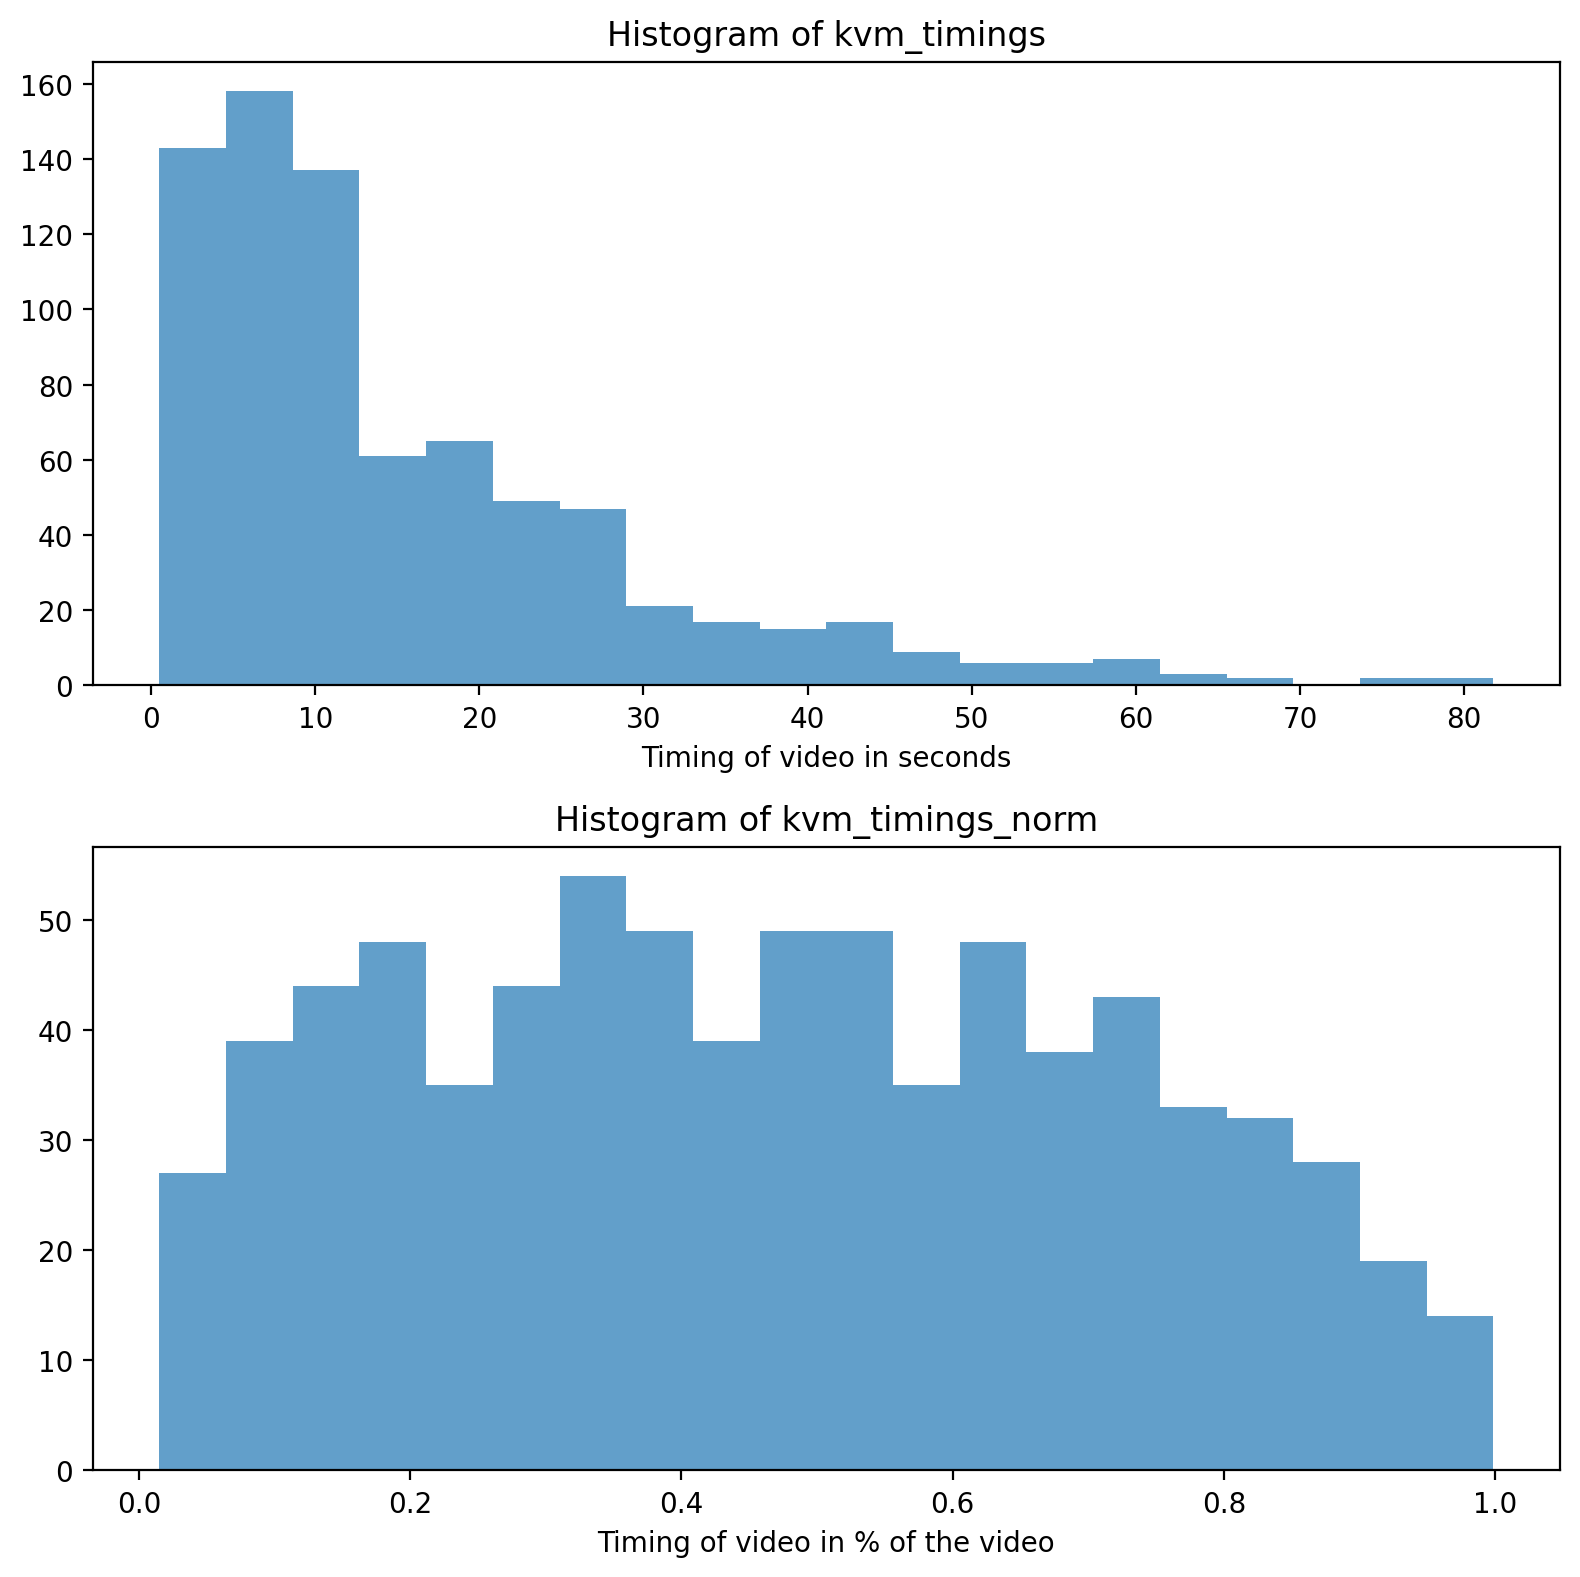

In [56]:
# Create a figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
# kvm_timings_norm
kvm_timings_norm = np.array(kvm_timings_norm)
# kvm_timings_norm = [k for k in kvm_timings_norm if k > 0]
mask = (np.array(kvm_timings_norm) > 0) & (np.array(kvm_timings_norm) < 0.999)

kw = dict(
    bins=20,
    alpha=0.7
)

# Plot histograms on separate axes
axes[0].hist(np.array(kvm_timings)[mask], **kw)
axes[0].set_title('Histogram of kvm_timings')
axes[0].set_xlabel('Timing of video in seconds')

axes[1].hist(kvm_timings_norm[mask], **kw)
axes[1].set_title('Histogram of kvm_timings_norm')
axes[1].set_xlabel('Timing of video in % of the video')

# axes[2].hist(video_lengths, **kw)
# axes[2].set_title('Histogram of video duration')
# axes[2].set_xlabel('seconds')

# axes[3].hist(kvm_per_video, **kw)
# axes[3].set_title('Histogram of kvm_per_video')
# axes[3].set_xlabel('count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('hist_kvms.png')
plt.show()

In [86]:
# Теперь уменьшаем количество ключевых моментов объединяя совсем соседние моменты в один

def kvm_list_cut(kvms: list, alpha=1, beta=8) -> list:
    '''
    Unite two consequent kvms into one if they are closed than max(kvm)/beta
    '''
    m = max(kvms)
    new_kvms = []
    i = 0
    # print(m / beta)
    while i < len(kvms) - 1:
        # if (s := kvms[i] + kvms[i + 1]) <= m * alpha:
        if abs(kvms[i] - kvms[i + 1]) <= m / beta:
            # new_kvms.append(s / 2)
            new_kvms.append(kvms[i])
            i += 2
        else:
            new_kvms.append(kvms[i])
            i += 1
    if i == len(kvms) - 1:
        new_kvms.append(kvms[-1])
    # newp = params.copy()
    # newp['timing_parts'] = new_kvms
    # assert sum(kvms) == sum(new_kvms), f'{sum(kvms)=}, {sum(new_kvms)=}'
    return new_kvms

kvm_list = output_cfg['video_ad14']
print(f'{kvm_list=}')

new_kvm_list = kvm_list_cut(kvm_list)
print(f'{new_kvm_list=}')
# new_kvm_list = kvm_list_cut(new_kvm_list)
# print(f'{new_kvm_list=}')

kvm_list=[0.0, 1.0, 1.68, 2.44, 3.04, 4.36, 10.64, 17.44, 19.72, 24.2, 36.76, 44.16, 51.28]
new_kvm_list=[0.0, 1.68, 3.04, 10.64, 17.44, 24.2, 36.76, 44.16, 51.28]


In [92]:
# Делаем это для всего ./kvm_threshold_only1.json
with open('./kvm_threshold_only1.json', 'r') as f:
    cfg = json.load(f)

cfg_cut = {}
for name, kvms in cfg.items():
    cfg_cut[name] = kvm_list_cut(kvms)

with open('kvm_threshold_only1_cut.json', 'w') as f:
    json.dump(cfg_cut, f, indent=4)
    
cfg_cut['video_ad1']

[0.0,
 50.717333333333336,
 55.18846666666667,
 59.49276666666667,
 63.1631,
 75.24183333333333,
 81.7817,
 100.4003]

Те же графики по kvm но для cut версии

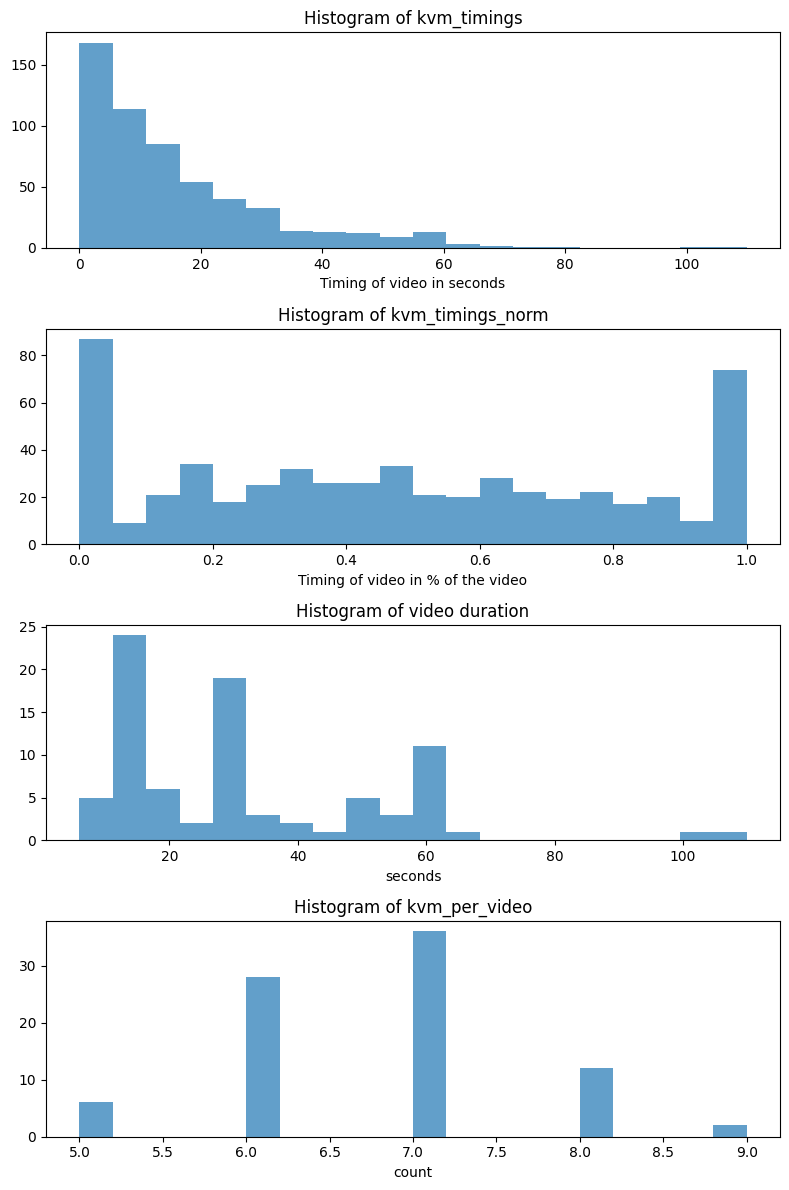

In [93]:
kvm_timings = []
kvm_timings_norm = []
kvm_per_video = []
video_lengths = []
for k, v in tqdm(cfg_cut.items()):
    kvm_timings += v
    kvm_timings_norm += list(np.array(v) / get_video_duration(path_videos / f'{k}.mp4')[0])
    kvm_per_video += [len(v)]
    video_lengths += [get_video_duration(path_videos / f'{k}.mp4')[0]]

# Create a figure and axes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 12))

kw = dict(
    bins=20,
    alpha=0.7
)

# Plot histograms on separate axes
axes[0].hist(kvm_timings, **kw)
axes[0].set_title('Histogram of kvm_timings')
axes[0].set_xlabel('Timing of video in seconds')

axes[1].hist(kvm_timings_norm, **kw)
axes[1].set_title('Histogram of kvm_timings_norm')
axes[1].set_xlabel('Timing of video in % of the video')

axes[2].hist(video_lengths, **kw)
axes[2].set_title('Histogram of video duration')
axes[2].set_xlabel('seconds')

axes[3].hist(kvm_per_video, **kw)
axes[3].set_title('Histogram of kvm_per_video')
axes[3].set_xlabel('count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('hist_kvms.png')
plt.show()

# video durations configs


In [108]:
import os
import json
from moviepy.editor import VideoFileClip

def create_video_duration_config(directory, output_json):
    video_durations = {}
    
    for root, dirs, files in os.walk(directory):
        for file in tqdm(files):
            if file.endswith('.mp4'):
                file_path = os.path.join(root, file)
                base_name = os.path.splitext(file)[0]
                
                with VideoFileClip(file_path) as video:
                    duration = video.duration  # Duration in seconds
                
                video_durations[base_name] = duration

    # Save the dictionary to a JSON file
    with open(output_json, 'w') as json_file:
        json.dump(video_durations, json_file, indent=4)

# Example usage
pa = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
    / 'content' / 'video_data'
create_video_duration_config(pa, 'video_durations.json')

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:34<00:00,  2.45it/s]


(array([ 5., 24.,  6.,  2., 19.,  3.,  2.,  1.,  5.,  3., 11.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([  6.01  ,  11.2055,  16.401 ,  21.5965,  26.792 ,  31.9875,
         37.183 ,  42.3785,  47.574 ,  52.7695,  57.965 ,  63.1605,
         68.356 ,  73.5515,  78.747 ,  83.9425,  89.138 ,  94.3335,
         99.529 , 104.7245, 109.92  ]),
 <BarContainer object of 20 artists>)

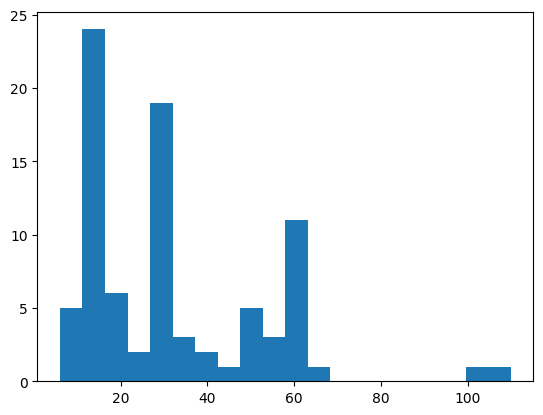

In [110]:
plt.hist(json.load(open('video_durations.json', 'r')).values(), bins=20)

# plot midi key moment extraction

300.5


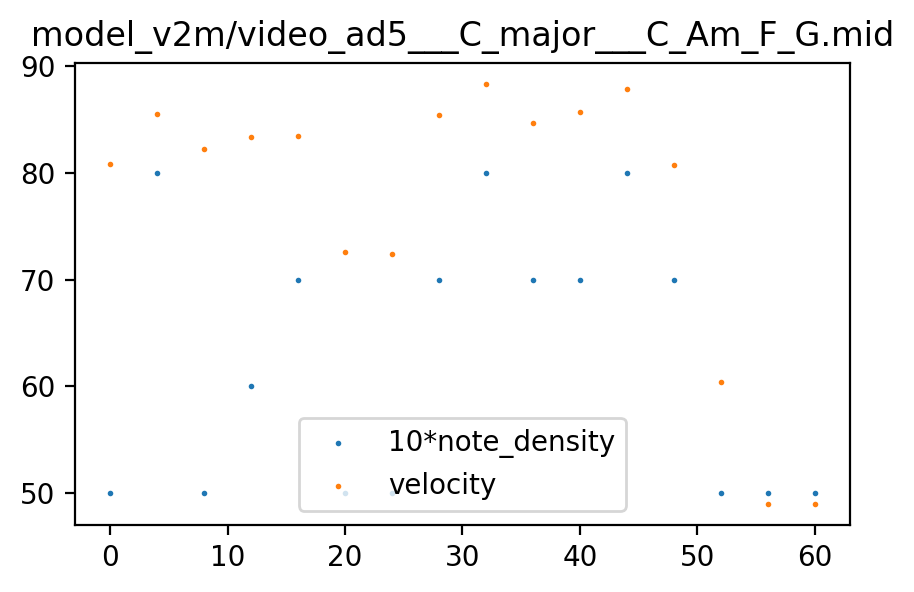

In [134]:
from video_utils.metrics import get_key_midi_moments
import mido

def get_midi_duration(file_path):
    midi = mido.MidiFile(file_path)
    return midi.length

def plot_midi_momets(midi, title=None):
    if title is None:
        title = midi
    kvm_d, arr_d = get_key_midi_moments(path_midi=midi, method='density', return_all_scores=True, duration=30)
    kvm_v, arr_v = get_key_midi_moments(path_midi=midi, method='velocity', return_all_scores=True, duration=30)

    plt.figure(figsize=(5, 3))
    plt.title(title)
    plt.scatter([a[0].offset for a in arr_d], [10 * a[1] for a in arr_d], s=1, label='10*note_density')
    plt.scatter([a[0].offset for a in arr_v], [a[1] for a in arr_v], s=1, label='velocity')
    plt.legend()
    plt.show()

midi = 'model_v2m/video_ad5___C_major___C_Am_F_G.mid'
# midi = 'model_v2m/video_ad14___D_major___D_G_A_D.mid'
# midi = 'model_v2m/video_ad25___G_major___C.mid'

print(get_midi_duration(midi))
plot_midi_momets(midi)

300.5


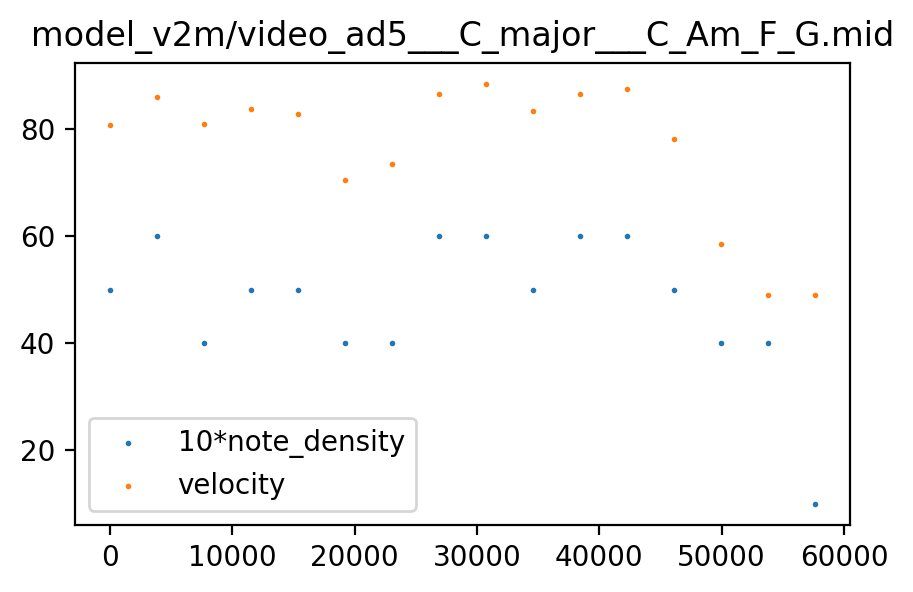

In [151]:
from video_utils.metrics import get_key_midi_moments,  get_key_midi_moments_2
import mido

def get_midi_duration(file_path):
    midi = mido.MidiFile(file_path)
    return midi.length

def plot_midi_momets(midi, title=None, duration=None):
    if title is None:
        title = midi
    kvm_d, arr_d = get_key_midi_moments_2(path_midi=midi, method='density', return_all_scores=True, duration=duration)
    kvm_v, arr_v = get_key_midi_moments_2(path_midi=midi, method='velocity', return_all_scores=True, duration=duration)
    plt.figure(figsize=(5, 3))
    plt.title(title)
    plt.scatter([a[0] for a in arr_d], [10 * a[1] for a in arr_d], s=1, label='10*note_density')
    plt.scatter([a[0] for a in arr_v], [a[1] for a in arr_v], s=1, label='velocity')
    plt.legend()
    plt.show()

midi = 'model_v2m/video_ad5___C_major___C_Am_F_G.mid'
# midi = 'model_v2m/video_ad14___D_major___D_G_A_D.mid'
# midi = 'model_v2m/video_ad25___G_major___C.mid'

print(get_midi_duration(midi))
plot_midi_momets(midi, duration=30)

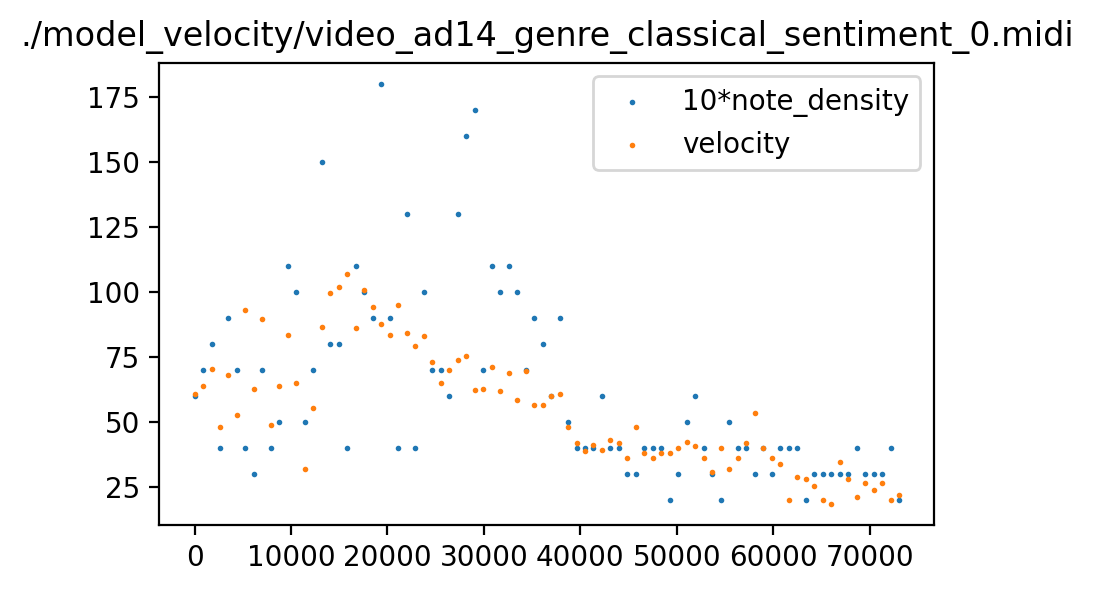

In [152]:
plot_midi_momets('./model_velocity/video_ad14_genre_classical_sentiment_0.midi')

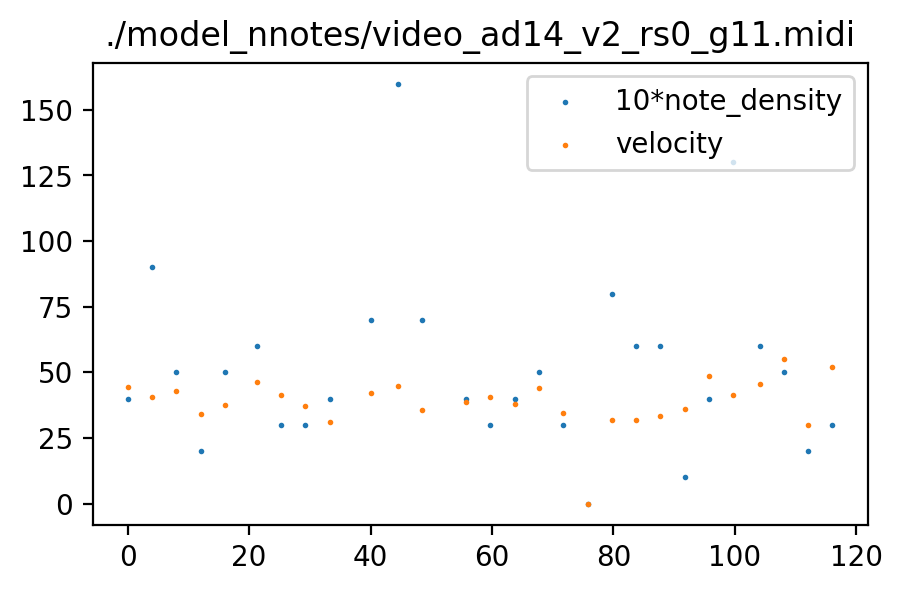

In [ ]:
plot_midi_momets('./model_nnotes/video_ad14_v2_rs0_g11.midi')

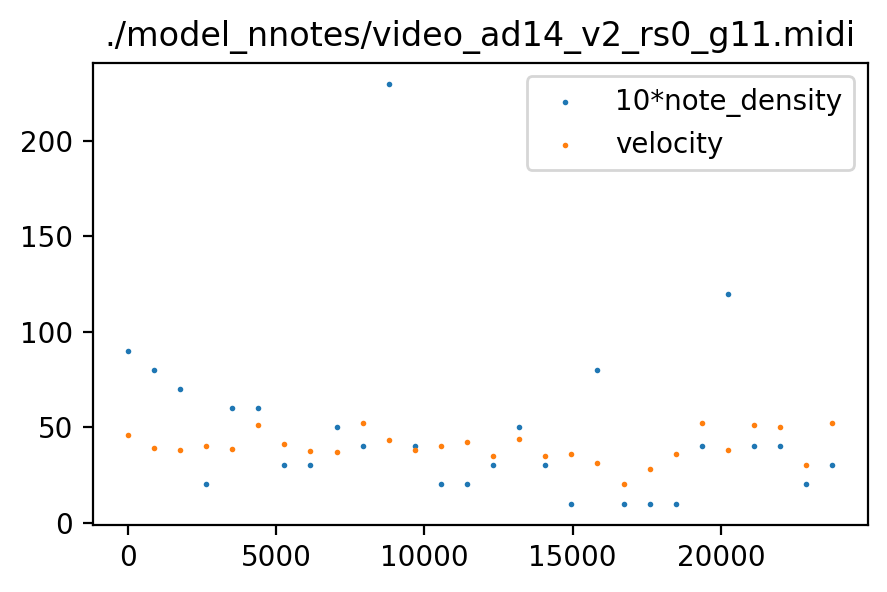

In [153]:
plot_midi_momets('./model_nnotes/video_ad14_v2_rs0_g11.midi')

# plots of kvm x key_midi_events for different models

Пытаемся по этим графика придумать метрику соответсвия музыки видео, которая будет удовлетворять
- Video2Music по ней будет не топ1
- Значения разумные - близки к значениями метрики на оригинальной музыке, не сильно превосходят

Что на графиках:
- одна из 4(5) моделей
- key video moments
- key midi moments

0it [00:00, ?it/s]

model_v2m/video_ad14___C_major___C_Am_F_G.mid
model_v2m/video_ad5___D_major___D_G_A_D.mid
model_v2m/video_ad25___G_major___C.mid
model_v2m/video_ad32___C_major___C_Am_F_G.mid
model_v2m/video_ad38___C_major___C_Am_F_G.mid


1it [00:10, 10.39s/it]

model_nnotes/video_ad14_v2_rs0_g1.midi
model_nnotes/video_ad5_v2_rs0_g0.midi
model_nnotes/video_ad25_v2_rs0_g2.midi
model_nnotes/video_ad32_v2_rs0_g11.midi
model_nnotes/video_ad38_v2_rs0_g11.midi


2it [00:18,  8.77s/it]

model_variations/variations_video_ad14_A_A1_A2_A3_A4_A5_A6_A7_rs0_t5128_ngen10696.midi
model_variations/variations_video_ad5_A_A1_A2_A3_A4_A5_rs1_t3003_ngen8022.midi
model_variations/variations_video_ad25_A_A1_A2_A3_A4_A5_A6_A7_A8_rs1_t5532_ngen12033.midi
model_variations/variations_video_ad32_A_A1_A2_A3_A4_A5_A6_rs1_t6006_ngen9359.midi
model_variations/variations_video_ad38_A_A1_A2_A3_A4_A5_A6_rs1_t5101_ngen9359.midi


3it [00:25,  8.24s/it]

model_velocity/video_ad14_genre_classical_sentiment_0.midi
model_velocity/video_ad5_genre_pop_sentiment_0.midi
model_velocity/video_ad25_genre_classical_sentiment_0.midi
model_velocity/video_ad32_genre_rock_sentiment_0.midi
model_velocity/video_ad38_genre_rock_sentiment_1.midi


4it [00:35,  8.85s/it]

model_original/music_orig_video_ad14.mid
model_original/music_orig_video_ad54.mid
model_original/music_orig_video_ad25.mid
model_original/music_orig_video_ad32.mid
model_original/music_orig_video_ad38.mid


5it [00:41,  8.30s/it]


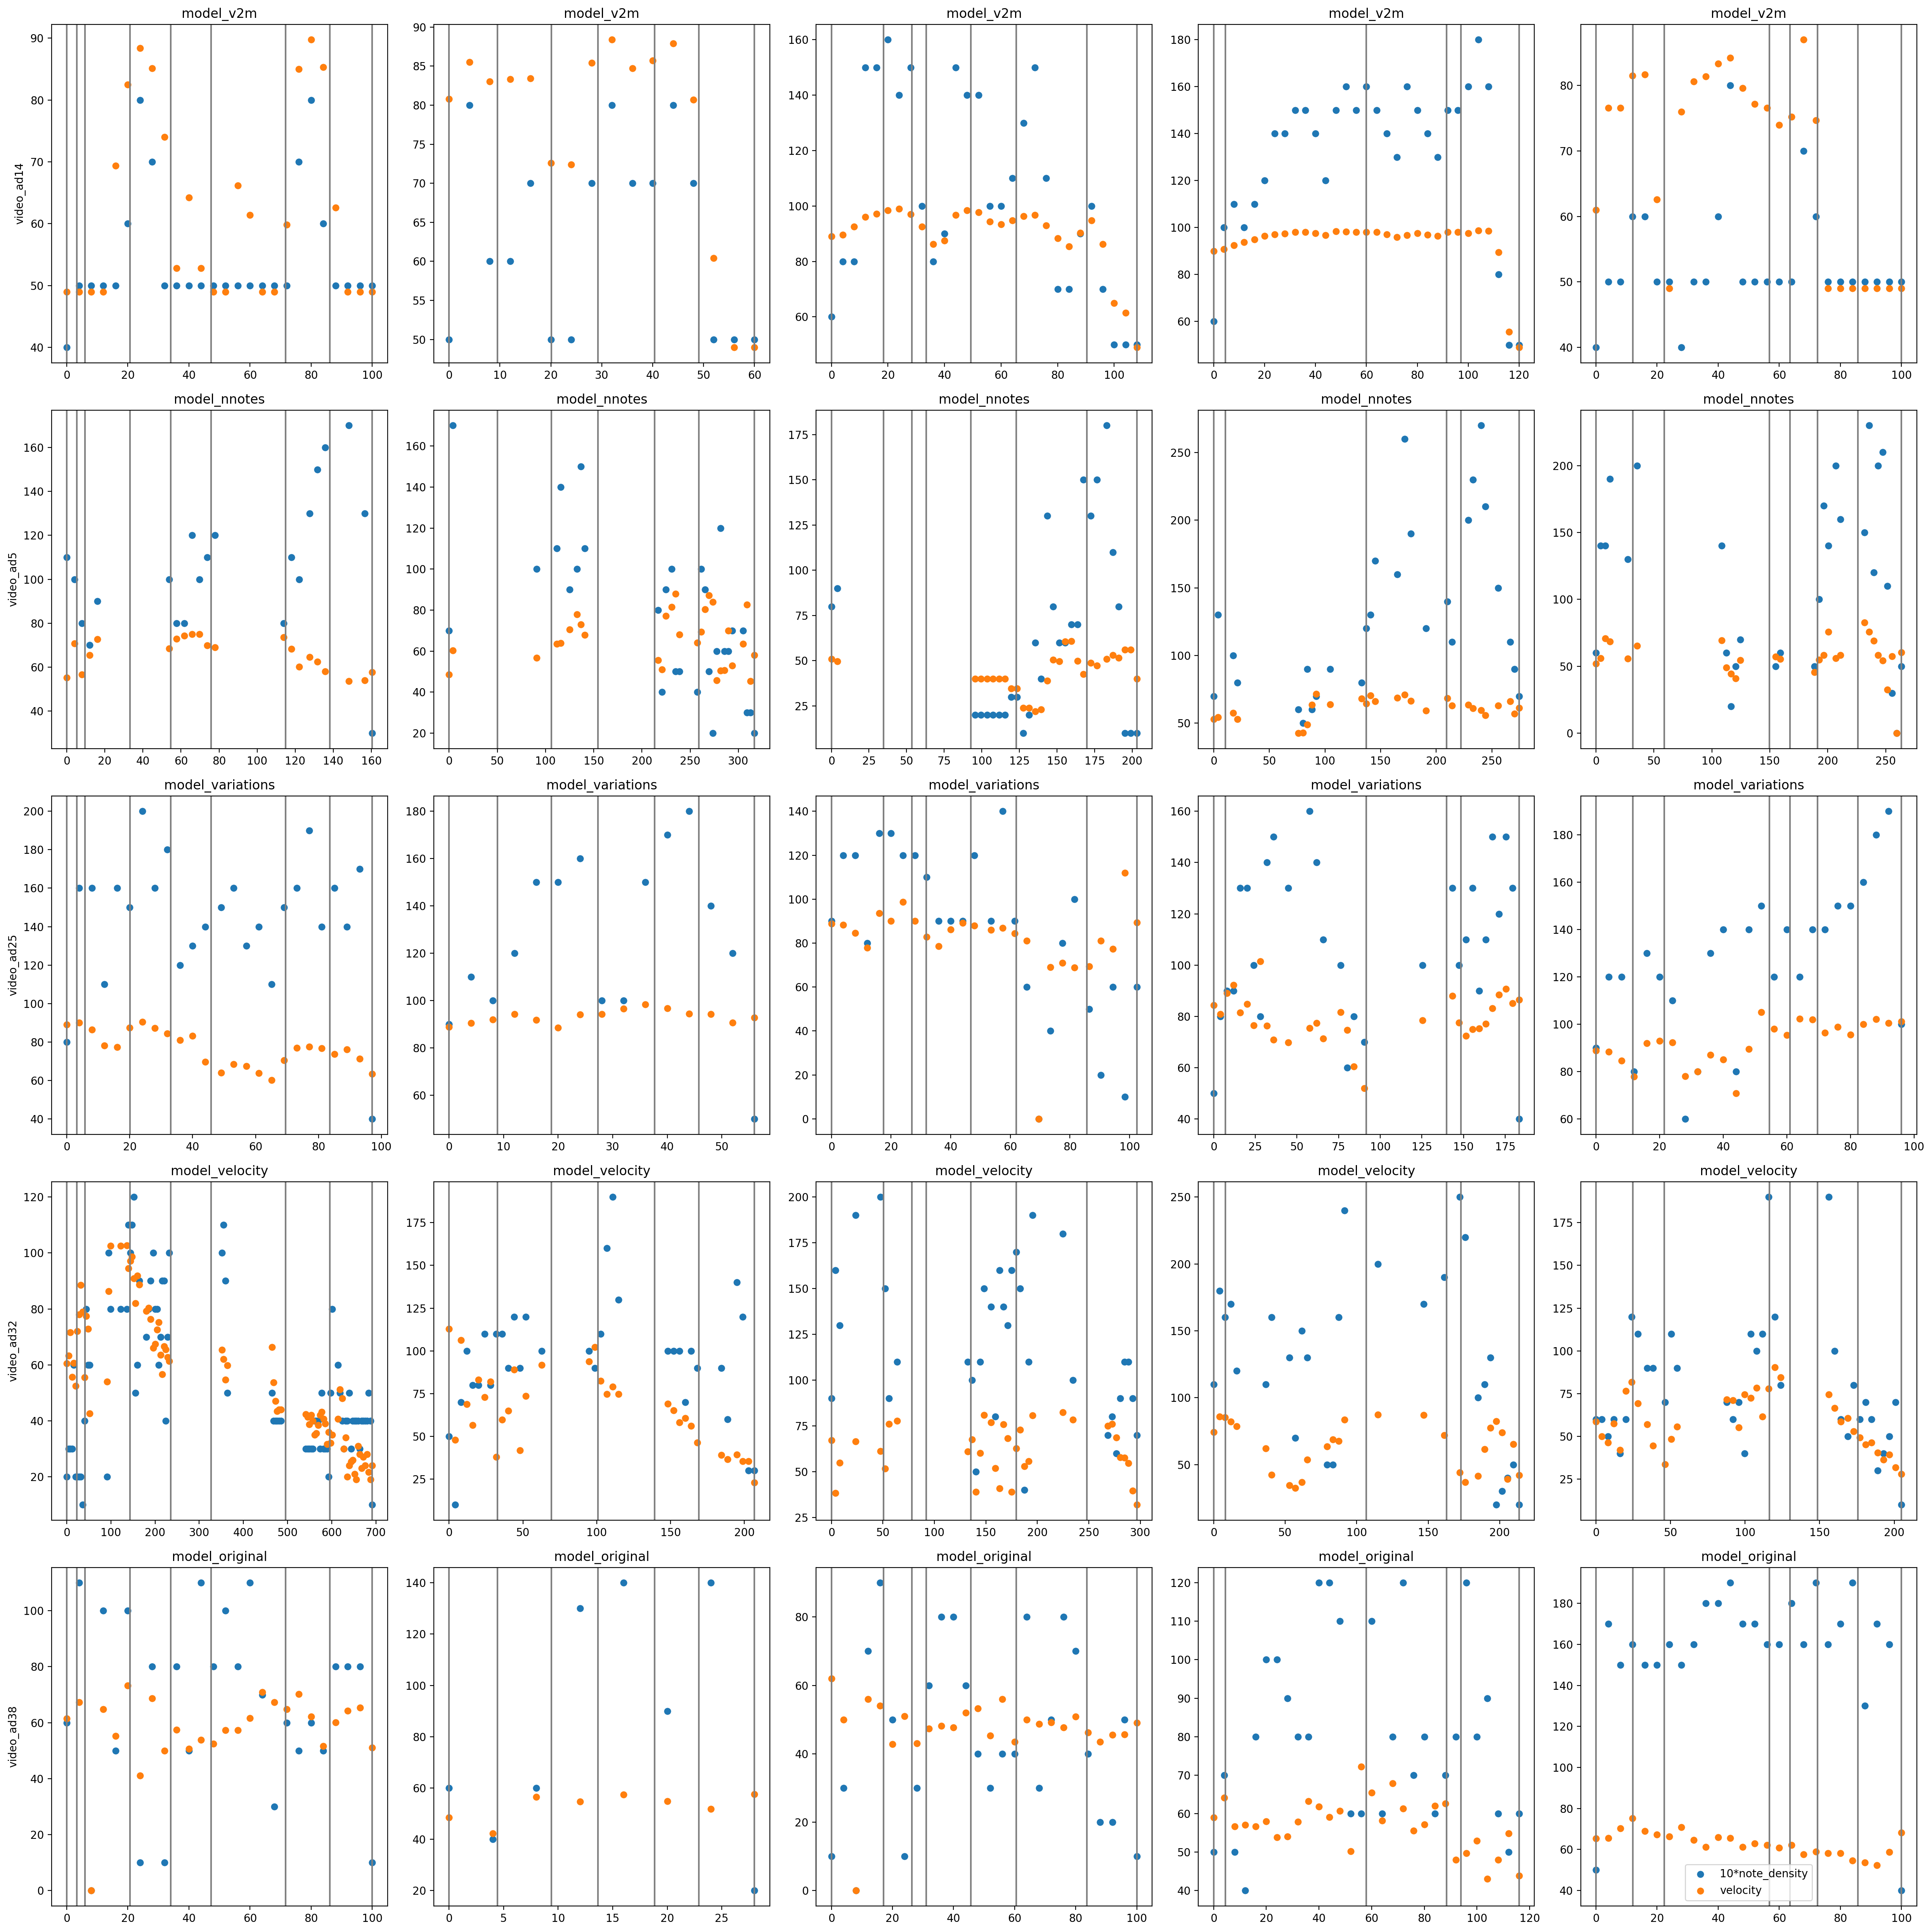

In [201]:
import os

def find_midi_file(containing_str, directory):
    matched_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if containing_str in file and file.endswith(('.mid', '.midi')):
                relative_path = os.path.relpath(os.path.join(root, file), directory)
                # matched_files.append(relative_path)
                return relative_path
    return None
    
model_paths = [
    'model_v2m',
    'model_nnotes',
    'model_variations',
    'model_velocity',
    'model_original'
    ][:]

with open('kvm_threshold_only1_cut.json', 'r') as f:
    kvms_all = json.load(f)
    
# TODO generate examples for each video
indexes = ('d5', 14, 25, 32, 38)[:]

video_names = [name for name in kvms_all.keys() if name.endswith(tuple([str(a) for a in indexes]))] 

with open('video_durations.json', 'r') as f:
    video_durations = json.load(f)

# grid of plots: n_models x m_videos
nrows = len(model_paths)
ncols = len(video_names)

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * nrows , 10 * ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
for irow, model in tqdm(enumerate(model_paths)):
    for icol, video_name in enumerate(video_names):
        if irow == 0:
            axes[icol, 0].set_ylabel(video_name)
            
        path_midi = find_midi_file(video_name, model)
        if path_midi is None:
            continue
        path_midi = Path(model) / path_midi
        print(path_midi)

        duration = video_durations[video_name]
        if model != 'model_v2m':
            duration = None

        kvm_d, arr_d = get_key_midi_moments(path_midi=path_midi, method='density', return_all_scores=True, duration=duration)
        kvm_v, arr_v = get_key_midi_moments(path_midi=path_midi, method='velocity', return_all_scores=True, duration=duration)

        axes[irow, icol].set_title(model)
        axes[irow, icol].scatter([a[0] for a in arr_d], [10 * a[1] for a in arr_d], s=30, label='10*note_density')
        axes[irow, icol].scatter([a[0] for a in arr_v], [a[1] for a in arr_v], s=30, label='velocity')

        kvm_normalised = np.array(kvms_all[video_name])
        kvm_normalised = kvm_normalised / max(kvm_normalised) * arr_v[-1][0]
        for kvm in kvm_normalised:
            axes[irow, icol].axvline(kvm, c='gray')


    #     break
    # break

plt.legend()
plt.tight_layout()
plt.savefig('kvm_kmm_models.png')

In [158]:
path_midi

PosixPath('model_velocity/video_ad14_genre_classical_sentiment_0.midi')

In [171]:
k, arr_v = get_key_midi_moments(path_midi=path_midi, method='density', return_all_scores=True, duration=duration)
k, arr_d = get_key_midi_moments(path_midi=path_midi, method='velocity', return_all_scores=True, duration=duration)

In [174]:
arr_v[::5]

[(0.0, 2),
 (20.0, 2),
 (40.0, 4),
 (95.25, 10),
 (Fraction(1727, 12), 10),
 (Fraction(494, 3), 9),
 (200.25, 8),
 (220.25, 9),
 (Fraction(1066, 3), 11),
 (Fraction(5671, 12), 4),
 (Fraction(1636, 3), 3),
 (Fraction(1696, 3), 4),
 (Fraction(1756, 3), 3),
 (Fraction(1843, 3), 6),
 (Fraction(7627, 12), 4),
 (Fraction(7867, 12), 4),
 (Fraction(8107, 12), 4)]

In [175]:
arr_d[::5]

[(0.0, 60.5),
 (20.0, 52.5),
 (40.0, 55.5),
 (95.25, 86.3),
 (Fraction(1727, 12), 97.2),
 (Fraction(494, 3), 88.66666666666667),
 (200.25, 67.375),
 (220.25, 66.66666666666667),
 (Fraction(1066, 3), 62.0),
 (Fraction(5671, 12), 47.0),
 (Fraction(1636, 3), 41.333333333333336),
 (Fraction(1696, 3), 35.5),
 (Fraction(1756, 3), 39.0),
 (Fraction(1843, 3), 40.666666666666664),
 (Fraction(7627, 12), 20.0),
 (Fraction(7867, 12), 19.0),
 (Fraction(8107, 12), 24.0)]